![](https://img.kaikeba.com/web/kkb_index/img_index_logo.png)

# Lesson-02 Assignment

   本周课程主要包含了图像基本操作中的卷积/滤波，以及最基础的特征描述算法————Harris Corner和SIFT。希望大家认真复习，理解图像求导/卷积的目的，以及特征的本质。
   本次作业分为阅读部分和算法部分。

## 本次作业的内容

### [Reading]:

You needn't finish reading all of them in just one week!
It's just good for you to know what's happening in this area and to figure out how people try to improve SIFT.

You needn't to remember all of them. 
But please DO REMEMBER procedures of SIFT and HoG. For those who're interested in SLAM, Orb is your inevitable destiny.

1. [optional] Bilateral Filter: https://blog.csdn.net/piaoxuezhong/article/details/78302920
2. Feature Descriptors:
   [Compulsory]
   Hog: https://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf
   SURF: https://www.vision.ee.ethz.ch/~surf/eccv06.pdf
   [optional]
   BRISK: http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.371.1343&rep=rep1&type=pdf
   Orb: http://www.willowgarage.com/sites/default/files/orb_final.pdf [Compulsory for SLAM Guys]
3. Preview parts:
   K-Means: I have no doubts about what you are going to read and where you gonna find the reading materials. There are tons of papers/blogs describing k-means. Just grab one and read.We'll talk about this topic in 3 weeks.

### [Coding]:
Finish 2D convolution/filtering by your self. 
What you are supposed to do can be described as "median blur", which means by using a sliding window on an image, your task is not going to do a normal convolution, but to find the median value within that crop.

You can assume your input has only one channel. (a.k.a a normal 2D list/vector) And you do need to consider the padding method and size. There are 2 padding ways: REPLICA & ZERO. When "REPLICA" is given to you, the padded pixels are same with the border pixels. E.g is [1 2 3] is your image, the padded version will be  [[(...1 1) 1 2 3 (3 3...)]  where how many 1 & 3 in the parenthesis depends on your padding size. When "ZERO", the padded version will be [(...0 0) 1 2 3 (0 0...)]

Assume your input's size of the image is W x H, kernel size's m x n. You may first complete a version with O(W·H·m·n log(m·n)) to O(W·H·m·n·m·n)).

Follow up 1: Can it be completed in a shorter time complexity?

In [22]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

class RaiseError(Exception):
    pass

def medianBlur(img, kernel, padding_way):
# Only gray_scale image is accepted

# Step 1: Do padding based on the given input img_size and padding_way
    if len(img.shape) != 2:
        raise RaiseError("The image should be gray scale! But your input image shape is {}.".format(img.shape))
    
    if padding_way not in ['REPLICA', 'ZERO']:
        raise KeyError('The padding_way {} is not supported. Supported padding_way: [REPLICA, ZERO]'.format(padding_way))

    img_padded = np.zeros((img.shape[0] + kernel[0] - 1, img.shape[1] + kernel[1] - 1))
    img_padded[(kernel[0]-1)//2:-(kernel[0]-1)//2, (kernel[1]-1)//2:-(kernel[1]-1)//2] = img[:,:]
    
    if padding_way == 'REPLICA':
        img_padded[:(kernel[0]-1)//2, (kernel[1]-1)//2:-(kernel[1]-1)//2] = img[0, :]
        img_padded[-(kernel[0]-1)//2:, (kernel[1]-1)//2:-(kernel[1]-1)//2] = img[-1, :]
        img_padded[(kernel[0]-1)//2:-(kernel[0]-1)//2, :(kernel[1]-1)//2 ] = img[:, 0].reshape(-1,1)
        img_padded[(kernel[0]-1)//2:-(kernel[0]-1)//2, -(kernel[1]-1)//2:] = img[:, -1].reshape(-1,1)
        
        img_padded[:(kernel[0]-1)//2,  :(kernel[1]-1)//2 ] = img[0,  0]
        img_padded[:(kernel[0]-1)//2,  -(kernel[1]-1)//2:] = img[0, -1]
        img_padded[-(kernel[0]-1)//2:, :(kernel[1]-1)//2 ] = img[-1, 0]
        img_padded[-(kernel[0]-1)//2:, -(kernel[1]-1)//2:] = img[-1,-1]
    
    elif padding_way == 'ZERO':
        img_padded[:(kernel[0]-1)//2 , :] = 0
        img_padded[-(kernel[0]-1)//2:, :] = 0
        img_padded[:, :(kernel[1]-1)//2 ] = 0
        img_padded[:, -(kernel[1]-1)//2:] = 0


# Step 2: Do convolution
    img_medianBlur = np.zeros((img.shape[0], img.shape[1]))
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            kernel_crop = sorted(img_padded[i:(i+kernel[0]), j:(j+kernel[1])].flatten())
            kernel_crop_length = len(kernel_crop)
            if kernel_crop_length%2 ==0:
                median_value = int((kernel_crop[kernel_crop_length//2] + kernel_crop[kernel_crop_length//2-1])/2)
            else:
                median_value = int(kernel_crop[kernel_crop_length//2])
            img_medianBlur[i, j] = median_value

    return img_medianBlur

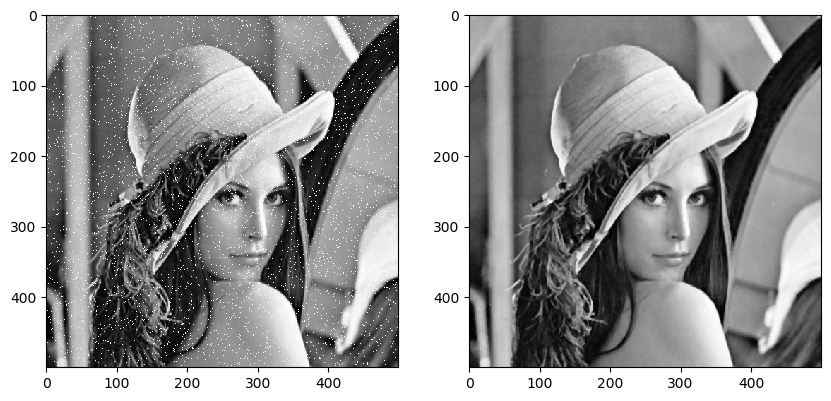

In [38]:
img = cv2.imread('lenna.jpg', 0)
plt.figure(figsize=(10,10), dpi=100)
plt.subplot(121)
# plt.imshow(medianBlur(img, (3,5), 'ZERO'), cmap='gray')
plt.imshow(img, cmap='gray')
plt.subplot(122)
plt.imshow(medianBlur(img, (3,3), 'REPLICA'), cmap='gray')

### [Reading + Pseudo Code]:
We haven't told RANSAC algorithm this week. So please try to do the reading.

And now, we can describe it here:
    We have 2 sets of points, say, Points A and Points B. We use A.1 to denote the first point in A, B.2 the 2nd point in B and so forth. Ideally, A.1 is corresponding to B.1, ... A.m corresponding B.m. However, it's obvious that the matching cannot be so perfect and the matching in our real world is like: 
    A.1-B.13, A.2-B.24, A.3-x (has no matching), x-B.5, A.4-B.24(This is a wrong matching) ...
    The target of RANSAC is to find out the true matching within this messy.
    
Algorithm for this procedure can be described like this:
    1. Choose 4 pair of points randomly in our matching points. Those four called "inlier" (中文： 内点) while others "outlier" (中文： 外点)
    2. Get the homography of the inliers
    3. Use this computed homography to test all the other outliers. And separated them by using a threshold into two parts:
        a. new inliers which is satisfied our computed homography
        b. new outliers which is not satisfied by our computed homography.
    4. Get our all inliers (new inliers + old inliers) and goto step 2
    5. As long as there's no changes or we have already repeated step 2-4 k, a number actually can be computed, times, we jump out of the recursion. The final homography matrix will be the one that we want.

[WARNING!!! RANSAC is a general method. Here we add our matching background to that.]

Your task: please complete pseudo code (it would be great if you hand in real code!) of this procedure.

Python:
def ransacMatching(A, B):
    A & B: List of List

Follow up 1. For step 3. How to do the "test“? Please clarify this in your code/pseudo code
Follow up 2. How do decide the "k" mentioned in step 5. Think about it mathematically!

You are supposed to hand in the code in 1 week.

In [40]:
# RANSAC伪代码：
n = 4 - the number of random points to pick every iteration in order to create the transform. 
k =  - the number of iterations to run 
t - the threshold for the square distance for a point to be considered as a match 
d - the threshold of number of points that need to be matched for the transform to be valid 
P - A accuracy that we hope the model to be
inlier_indexes_best = [] - The inlier list that has the most points

# 1.
K = 10000 # Set a big number firstly. Then adjust it based on the number of inlier points

for i in range(k):
    
    inlier_indexes  = []  #list of total indexes of inlier points 
    outlier_indexes = []  #list of total indexes of outlier points 
    inlier_indexes.append(n random indexes)
    outlier_indexes = (all indexes) - inlier_indexes
    inlier_A = list of n random points from Points A based on the inlier_indexes
    inlier_B = list of n random points from Points B based on the inlier_indexes

# 2.
    homography = cv2.getPerspectiveTransform(inlier_A, outlier_B)

# 3.
    for j in range(len(A)):
        inlier_index_j = list of n random indexes from outlier_indexes
        inlier_A_j = get a list of points from Points A based on the inlier_index_j
        inlier_B_j = get a list of points from Points B based on the inlier_index_j
        inlier_A_j_target = cv2.perspectiveTransform(inlier_A_j, homography_1, (n,2))
        
        t_j = 0
        for m in n:
            t_m = np.linalg.norm(inlier_B_j[m] - inlier_A_j_target[m])
            t_j += t_m
            
        if t_j < t:
            inlier_indexes.append[inlier_index_i]
            outlier_indexes.pop[inlier_index_i]
            
# 4.
    if len(inlier_indexes) > len(inlier_indexes_best):
        inlier_indexes_best = inlier_indexes
        homography_best = homography
        k = math.log(1 - P) / math.log(1 - pow(len(inlier_indexes) / len(A) , 4))

inlier_A_best = list of n random points from Points A based on the inlier_indexes_best
inlier_B_best = list of n random points from Points B based on the inlier_indexes_best
return homography_best, inlier_indexes_best

SyntaxError: invalid syntax (<ipython-input-40-e99b655472ec>, line 2)

### [作业截止时间]

作业能帮助你回顾课堂内容，你又可以通过作业进行代码实操。咱们可要认真、及时的完成作业哦！自布置作业起两周内提交，助教及时批改作业哦～逾期提交不批改。（特殊情况，请找班主任请假。）

这次的作业就到这里了！祝大家学习进步！

![image alt <](http://5b0988e595225.cdn.sohucs.com/images/20190420/1d1070881fd540db817b2a3bdd967f37.gif)